### Imports

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import subjects
from subjects import stat_kw
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from neuropy.utils.misc import flatten
from scipy import stats
from plotters import Plotter, get_nsd_vs_sd_df, get_nsd_vs_sd_df_by_state, add_zt_str, get_stats_from_annotation, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

grpdata = subjects.GroupData()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 4B: replay examples

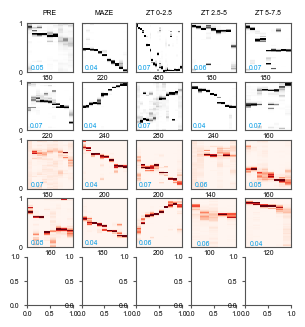

In [2]:
examples = subjects.GroupData().replay_examples

fig = subjects.SdFig().fig4()
subfig = fig.add_subfigure(fig.gs[:2, 0:2])
axs = subfig.subplots(5, 5)

dt = 0.02 * 1000
pf_cmaps = ["Greys", "Reds"]
zts = examples.zt.unique()
for i, grp in enumerate(["NSD", "SD"]):
    for i1, zt in enumerate(zts):
        events = examples[(examples.grp == grp) & (examples.zt == zt)]
        posteriors = events["posterior"].to_list()
        jumps = events["jd"].to_list()

        for i2, (p, jd) in enumerate(zip(posteriors, jumps)):
            jd = jd / p.shape[0]
            p = np.apply_along_axis(
                np.convolve, axis=0, arr=p, v=np.ones(2 * 1 + 1), mode="same"
            )
            nt = p.shape[1]

            # axs_col = 2 * i1 + i2
            ax = axs[2 * i + i2, i1]

            if grp == "SD" and zt == "5-7.5":
                cmap = "Blues"
            else:
                cmap = pf_cmaps[i]

            ax.pcolormesh(p, cmap=cmap, vmin=0, vmax=0.2, rasterized=True)
            ax.text(
                0.6, 7, f"{np.round(jd,2)}", color="#039be5", fontdict=dict(fontsize=5)
            )
            ax.spines["right"].set_visible(True)
            ax.spines["top"].set_visible(True)

            if (2 * i + i2) == 0:
                ax.set_title(zt)
            if i1 == 0:
                yticks = np.arange(p.shape[0])
                ax.set_yticks(yticks[[0, -1]], [0, 1])
            else:
                ax.set_yticks([])

            ax.set_xticks([nt // 2], [int(nt * dt)])
            ax.tick_params(length=0)

fig.savefig(subjects.figpath_sd / "replay_examples")

### 4C: proportion of replays

In [ ]:
file = "/home/nkinsky/Documents/sleep_deprivation/ProcessedData/replay_continuous_events_bak.npy"
data = np.load(file, allow_pickle=True).item()
pd.DataFrame(data["data"])

#Sessions = 13
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.960e-01 Stat=3.883e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.007e-01 Stat=1.817e+00
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:8.315e-02 Stat=2.000e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:4.018e-04 Stat=4.498e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.139e-04 Stat=5.466e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.976e-04 Stat=4.912e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

ZT 0-2.5_NSD vs. ZT 2.5-5_NSD: get_bootstrap_prob_paired, P_val:4.455e-01 Stat=3.078e-03
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_pai

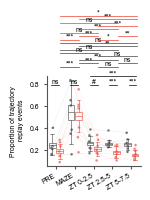

In [52]:
sessions = subjects.pf_sess()

jump_thresh = 40
assert jump_thresh in [20, 40]
save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"
prop_append = "" if jump_thresh == 40 else f"{jump_thresh}jd"

boot_df = getattr(subjects.GroupData(), f"continuous_replay_proportion_bootstrap{save_append}")
replay_df = getattr(grpdata, f"replay_continuous_events{save_append}")

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])

results_list = []
p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1), zorder=3).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    verbose=True,
))

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="prop", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)
ax.set_xlabel("")
ax.set_ylabel("Proportion of trajectory\n replay events")

fig.savefig(subjects.figpath_sd / f"replay_proportion_bootstrap{save_append}", format="svg")

In [11]:
results_df = stats_to_df(results_list)
filter_stats_df(results_df, figure="4")
# results_df

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",3.960e-01,3.883e-01
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",1.007e-01,1.817e+00
3,ZT 2.5-5_NSD,ZT 2.5-5_SD,"get_bootstrap_prob,",4.018e-04,4.498e+00
4,ZT 5-7.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",1.139e-04,5.466e+00
5,ZT 0-2.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",1.976e-04,4.912e+00
6,ZT 0-2.5_NSD,ZT 2.5-5_NSD,"get_bootstrap_prob_paired,",4.455e-01,3.078e-03
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",0.000e+00,-2.954e-01
8,MAZE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",0.000e+00,2.788e-01
9,ZT 2.5-5_NSD,ZT 5-7.5_NSD,"get_bootstrap_prob_paired,",3.232e-01,6.043e-03
12,PRE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",2.711e-01,-1.658e-02


#### Total number candidate events
See sd_replay_bootstrap.ipynb

#### Display stats for spreadsheet
pd.DataFrame(flatten(flatten(results_list)), columns=["comp1", "comp2", "test", "pval", "test_stat"])

In [13]:
# mean, median, IQR
boot_df["zt"] = pd.Categorical(boot_df["zt"], ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
boot_df.groupby(["grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
).reset_index()

grp        zt   is_cont                     
                      mean    median <lambda_0>
0  NSD       PRE  0.246395  0.246440   0.049232
1  NSD      MAZE  0.541820  0.547588   0.142103
2  NSD  ZT 0-2.5  0.262976  0.262032   0.034326
3  NSD  ZT 2.5-5  0.259898  0.258636   0.016765
4  NSD  ZT 5-7.5  0.253855  0.253305   0.025278
5   SD       PRE  0.193024  0.192110   0.034391
6   SD      MAZE  0.509893  0.513976   0.072462
7   SD  ZT 0-2.5  0.212004  0.210641   0.033627
8   SD  ZT 2.5-5  0.183693  0.183400   0.027595
9   SD  ZT 5-7.5  0.156288  0.154702   0.022625

### Proportion PBE events by brain-state
In sd_fig4_supp.ipynb.

### Proportion PBE events in 1h blocks (all blocks included)

In [ ]:
boot_df = subjects.GroupData().continuous_replay_proportion_1h_blocks_bootstrap
replay_df = grpdata.replay_continuous_events_1h_blocks

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])

p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p1.boxplot_sd2(palette=subjects.colors_sd(1), zorder=3).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=0.025,
    alpha_within=0.025,
    fontsize=5,
    verbose=True,
)

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="prop", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)## Replay proportion (1h blocks)

fig.savefig(subjects.figpath_sd / "replay_proportion_bootstrap_1h_blocks", format="svg")

### EDF 6D Proportion replay events (1h blocks keeping only 0-1, 4-5, 5-6)

In [12]:
# Quick filter function
from copy import deepcopy

def cut_1h_epochs(df_in):
    keep_inds = []
    zt_keep = ['PRE', 'MAZE', '0-1', '4-5', '5-6']
    for zt in zt_keep:
        keep_inds.extend(np.where(df_in.zt == zt)[0])
    keep_inds = np.sort(np.array(keep_inds))
    
    return df_in.iloc[keep_inds]
try:
    # Unit test
    df_test = deepcopy(replay_df)
    cut_1h_epochs(df_test).zt.unique()
except NameError:
    pass

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:4.022e-01 Stat=3.609e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:9.916e-02 Stat=1.842e+00
ZT 0-1_NSD vs. ZT 0-1_SD: get_bootstrap_prob, P_val:1.353e-01 Stat=1.590e+00
ZT 4-5_NSD vs. ZT 4-5_SD: get_bootstrap_prob, P_val:1.323e-04 Stat=4.847e+00
ZT 5-6_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:7.230e-06 Stat=6.016e+00
ZT 0-1_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:1.389e-04 Stat=4.825e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

ZT 0-1_NSD vs. ZT 4-5_NSD: get_bootstrap_prob_paired, P_val:3.444e-01 Stat=9.448e-03
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=-2.944e-0

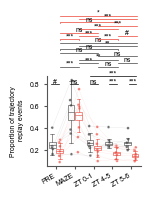

In [15]:
boot_df = add_zt_str(cut_1h_epochs(subjects.GroupData().continuous_replay_proportion_1h_blocks_bootstrap), epoch_str=("0-1", "4-5", "5-6"))
replay_df = add_zt_str(cut_1h_epochs(grpdata.replay_continuous_events_1h_blocks), epoch_str=("0-1", "4-5", "5-6"))

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])

results_list = []
p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1), zorder=3).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    verbose=True,
))

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="prop", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)## Replay proportion (1h blocks)
ax.set_xlabel("")
ax.set_ylabel("Proportion of trajectory\n replay events")

fig.savefig(subjects.figpath_sd / "replay_proportion_bootstrap_1h_blocks_simplified", format="svg")

In [20]:
results_df = stats_to_df(results_list)
filter_stats_df(results_df, figure= "EDF6D")
# filter_stats_df

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",4.022e-01,3.609e-01
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",9.916e-02,1.842e+00
3,ZT 4-5_NSD,ZT 4-5_SD,"get_bootstrap_prob,",1.323e-04,4.847e+00
4,ZT 5-6_NSD,ZT 5-6_SD,"get_bootstrap_prob,",7.230e-06,6.016e+00
5,ZT 0-1_NSD,ZT 5-6_SD,"get_bootstrap_prob,",1.389e-04,4.825e+00
6,ZT 0-1_NSD,ZT 4-5_NSD,"get_bootstrap_prob_paired,",3.444e-01,9.448e-03
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",0.000e+00,-2.944e-01
8,MAZE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",0.000e+00,2.700e-01
9,ZT 4-5_NSD,ZT 5-6_NSD,"get_bootstrap_prob_paired,",4.933e-01,-1.240e-04
12,PRE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",1.157e-01,-2.437e-02


### 4D: Number of replay events per hour
n is same as 4C - # candidate events

In [11]:
boot_df = subjects.GroupData().continuous_replay_number_bootstrap
norm_to_1h = True  # Normalize data to 1h sessions to match MAZE times
if norm_to_1h:
    boot_df.loc[boot_df.zt != "MAZE", "is_cont"] = boot_df[boot_df.zt != "MAZE"].is_cont/2.5
boot_df.groupby(["grp", "zt"], sort=False).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
).reset_index()

grp        zt     is_cont                        
                        mean      median  <lambda_0>
0  NSD       PRE  225.055867  224.800000   81.133333
1  NSD      MAZE  399.394333  390.000000  189.375000
2  NSD  ZT 0-2.5  335.977340  336.333333   51.200000
3  NSD  ZT 2.5-5  249.504100  251.600000   36.416667
4  NSD  ZT 5-7.5  213.236607  213.000000   32.700000
5   SD       PRE  154.723851  154.114286   47.828571
6   SD      MAZE  311.897371  310.285714   94.857143
7   SD  ZT 0-2.5  236.167109  237.657143   33.771429
8   SD  ZT 2.5-5  226.532731  226.000000   31.771429
9   SD  ZT 5-7.5  115.840263  116.285714   25.428571

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: p <= 2.50e-02

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.105e-01 Stat=8.065e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.569e-01 Stat=1.480e+00
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:1.412e-02 Stat=3.146e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:2.497e-01 Stat=9.679e-01
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:3.106e-04 Stat=4.519e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:0.000e+00 Stat=7.394e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: p <= 2.50e-02

ZT 0-2.5_NSD vs. ZT 2.5-5_NSD: get_bootstrap_prob_paired, P_val:2.900e-02 Stat=8.647e+01
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:8.500e-02 Stat=-1.743e+02
MAZE_NSD vs. ZT 0-2.5_NSD: get_bootstrap_prob_paired, P_val:3.555e-01 Stat=6.342e+01
ZT 2.5-5_NSD vs. ZT 5-7.5_NSD: ge

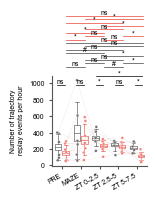

In [21]:
jump_thresh = 40
assert jump_thresh in [20, 40]
norm_to_1h = True  # Normalize data to 1h sessions to match MAZE times
save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"
prop_append = "" if jump_thresh == 40 else f"{jump_thresh}jd"

boot_df = add_zt_str(getattr(subjects.GroupData(), f"continuous_replay_number_bootstrap{save_append}"), 
                             epoch_str=("0-2.5", "2.5-5", "5-7.5"))
replay_df = add_zt_str(getattr(grpdata, f"continuous_replay_number{save_append}"), 
                             epoch_str=("0-2.5", "2.5-5", "5-7.5"))

if norm_to_1h:
    boot_df.loc[boot_df.zt != "MAZE", "is_cont"] = boot_df[boot_df.zt != "MAZE"].is_cont/2.5
    replay_df.loc[replay_df.zt != "MAZE", "is_cont"] = replay_df[replay_df.zt != "MAZE"].is_cont/2.5

# boot_df = subjects.GroupData().continuous_replay_number_bootstrap
# replay_df = grpdata.continuous_replay_number

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])
# ax.set_ylim(0, 1200)

results_list = []
p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=0.025,
    alpha_within=0.025,
    fontsize=5,
    verbose=True,
))
palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)

ax.set_xlabel("")
ax.set_ylabel("Number of trajectory\n replay events per hour")

fig.savefig(subjects.figpath_sd / f"replay_number_bootstrap{save_append}", format="svg")

In [22]:
results_df = stats_to_df(results_list)
filter_stats_df(results_df, figure="4")

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",3.105e-01,8.065e-01
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",1.569e-01,1.480e+00
3,ZT 2.5-5_NSD,ZT 2.5-5_SD,"get_bootstrap_prob,",2.497e-01,9.679e-01
4,ZT 5-7.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",3.106e-04,4.519e+00
5,ZT 0-2.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",0.000e+00,7.394e+00
6,ZT 0-2.5_NSD,ZT 2.5-5_NSD,"get_bootstrap_prob_paired,",2.900e-02,8.647e+01
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",8.500e-02,-1.743e+02
8,MAZE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",3.555e-01,6.342e+01
9,ZT 2.5-5_NSD,ZT 5-7.5_NSD,"get_bootstrap_prob_paired,",1.930e-02,3.627e+01
12,PRE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",4.530e-02,-1.109e+02


### Number events (1h blocks)

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: p <= 2.50e-02

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.143e-01 Stat=7.899e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.612e-01 Stat=1.462e+00
0-1_NSD vs. 0-1_SD: get_bootstrap_prob, P_val:1.611e-02 Stat=3.311e+00
1-2_NSD vs. 1-2_SD: get_bootstrap_prob, P_val:2.160e-02 Stat=2.802e+00
2-3_NSD vs. 2-3_SD: get_bootstrap_prob, P_val:4.394e-01 Stat=2.486e-01
3-4_NSD vs. 3-4_SD: get_bootstrap_prob, P_val:3.423e-01 Stat=5.997e-01
4-5_NSD vs. 4-5_SD: get_bootstrap_prob, P_val:1.292e-01 Stat=1.647e+00
5-6_NSD vs. 5-6_SD: get_bootstrap_prob, P_val:1.337e-03 Stat=3.833e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: p <= 2.50e-02

0-1_NSD vs. 1-2_NSD: get_bootstrap_prob_paired, P_val:3.726e-01 Stat=2.116e+01
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:1.486e-01 Stat=1.621e+02
MAZE_NSD vs. 0-1_NSD: get_b

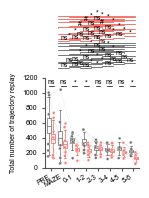

In [12]:
boot_df = add_zt_str(subjects.GroupData().continuous_replay_number_1h_blocks_bootstrap, 
                             epoch_str=("0-1", "4-5", "5-6"))
replay_df = add_zt_str(grpdata.continuous_replay_number_1h_blocks, 
                             epoch_str=("0-1", "4-5", "5-6"))

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])
ax.set_ylim(0, 1200)

p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=0.025,
    alpha_within=0.025,
    fontsize=5,
    verbose=True,
)
palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)

ax.set_xlabel("")
ax.set_ylabel("Total number of trajectory replay")

fig.savefig(subjects.figpath_sd / "replay_number_bootstrap_1h_blocks", format="svg")

### EDF 6D: Number events 1h blocks simplified (PRE, MAZE, 0-1, 4-5, 5-6 only)

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: p <= 2.50e-02

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.143e-01 Stat=7.899e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.612e-01 Stat=1.462e+00
ZT 0-1_NSD vs. ZT 0-1_SD: get_bootstrap_prob, P_val:1.611e-02 Stat=3.311e+00
ZT 4-5_NSD vs. ZT 4-5_SD: get_bootstrap_prob, P_val:1.292e-01 Stat=1.647e+00
ZT 5-6_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:1.337e-03 Stat=3.833e+00
ZT 0-1_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:4.160e-06 Stat=6.386e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: p <= 2.50e-02

ZT 0-1_NSD vs. ZT 4-5_NSD: get_bootstrap_prob_paired, P_val:8.660e-02 Stat=1.065e+02
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:1.486e-01 Stat=1.621e+02
MAZE_NSD vs. ZT 0-1_NSD: get_bootstrap_prob_paired, P_val:4.092e-01 Stat=3.533e+01
ZT 4-5_NSD vs. ZT 5-6_NSD: get_bootstrap_prob_paired, P_

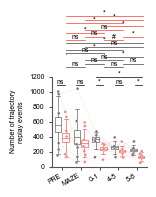

In [34]:
boot_df = add_zt_str(cut_1h_epochs(subjects.GroupData().continuous_replay_number_1h_blocks_bootstrap), "zt", 
                    ("0-1", "4-5", "5-6"))
replay_df = cut_1h_epochs(grpdata.continuous_replay_number_1h_blocks)

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])
ax.set_ylim(0, 1200)
results_list = []
p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=0.025,
    alpha_within=0.025,
    fontsize=5,
    verbose=True,
))
palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)

ax.set_xlabel("")
ax.set_ylabel("Number of trajectory\nreplay events")

fig.savefig(subjects.figpath_sd / "replay_number_bootstrap_1h_blocks_simplified", format="svg")

In [46]:
results_df = stats_to_df(results_list)
results_df = filter_stats_df(results_df, figure="EDF6D")
results_df.to_csv("/home/nkinsky/Documents/sleep_deprivation/ProcessedData/nevents_1h_blocks.csv")
results_df

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",1.226e-01,1.598e+00
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",2.635e-01,8.581e-01
3,ZT 4-5_NSD,ZT 4-5_SD,"get_bootstrap_prob,",2.843e-01,8.737e-01
4,ZT 5-6_NSD,ZT 5-6_SD,"get_bootstrap_prob,",2.840e-01,9.072e-01
5,ZT 0-1_NSD,ZT 5-6_SD,"get_bootstrap_prob,",9.320e-02,1.911e+00
6,ZT 0-1_NSD,ZT 4-5_NSD,"get_bootstrap_prob_paired,",3.639e-01,-3.550e-03
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",3.230e-01,5.879e-03
8,MAZE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",2.116e-01,-7.470e-03
9,ZT 4-5_NSD,ZT 5-6_NSD,"get_bootstrap_prob_paired,",7.930e-02,9.170e-03
12,PRE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",4.337e-01,-1.591e-03


In [25]:
from plotters import add_zt_str
add_zt_str(boot_df, epoch_str=("0-1", "4-5", "5-6"))

,grp,zt,is_cont
0,NSD,PRE,224.666667
1,NSD,MAZE,175.166667
2,NSD,ZT 0-1,300.333333
6,NSD,ZT 4-5,304.833333
7,NSD,ZT 5-6,247.500000
...,...,...,...
159992,SD,PRE,163.142857
159993,SD,MAZE,316.428571
159994,SD,ZT 0-1,259.714286
159998,SD,ZT 4-5,244.428571


p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.041e-01 Stat=8.262e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:1.001e-01 Stat=1.860e+00
ZT 0-1_NSD vs. ZT 0-1_SD: get_bootstrap_prob, P_val:1.352e-02 Stat=3.382e+00
ZT 4-5_NSD vs. ZT 4-5_SD: get_bootstrap_prob, P_val:1.350e-01 Stat=1.610e+00
ZT 5-6_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:1.323e-03 Stat=3.794e+00
ZT 0-1_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:2.330e-06 Stat=6.470e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

ZT 0-1_NSD vs. ZT 4-5_NSD: get_bootstrap_prob_paired, P_val:8.180e-02 Stat=1.092e+02
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:8.360e-02 Stat=-1.752e+0

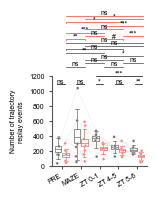

In [50]:
boot_df = add_zt_str(cut_1h_epochs(subjects.GroupData().continuous_replay_number_1h_blocks_1hpre_bootstrap), epoch_str=("0-1", "4-5", "5-6"))
replay_df = add_zt_str(cut_1h_epochs(grpdata.continuous_replay_number_1h_blocks_1hpre), epoch_str=("0-1", "4-5", "5-6"))

fig = subjects.SdFig().fig4(8, 6)

ax = fig.subplot(fig.gs[3, 0])
ax.set_ylim(0, 1200)

results_list = []
p1 = Plotter(data=boot_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    verbose=True,
))
palette_light = subjects.colors_sd_light()
p2 = Plotter(data=replay_df, x="zt", y="is_cont", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)

ax.set_xlabel("")
ax.set_ylabel("Number of trajectory\nreplay events")

fig.savefig(subjects.figpath_sd / "replay_number_bootstrap_1h_blocks_1hpre_simplified", format="svg")

In [51]:
results_df = stats_to_df(results_list)
results_df = filter_stats_df(results_df, figure="EDF6D")
results_df.to_csv("/home/nkinsky/Documents/sleep_deprivation/ProcessedData/number_replay_events_1h_blocks.csv")

### 4E: candidate PBE and continuous replay PBE duration

In [19]:
boot_df = subjects.GroupData().continuous_replay_PBE_duration_bootstrap
boot_df.groupby(["grp", "zt"], sort=False).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
).reset_index()

grp        zt pbe_duration                     
                         mean    median <lambda_0>
0  NSD       PRE     0.190558  0.189963   0.019655
1  NSD      MAZE     0.184717  0.185590   0.006946
2  NSD  ZT 0-2.5     0.188006  0.187853   0.013707
3  NSD  ZT 2.5-5     0.190506  0.190670   0.019955
4  NSD  ZT 5-7.5     0.193053  0.193093   0.024078
5   SD       PRE     0.200787  0.201954   0.014370
6   SD      MAZE     0.195149  0.195393   0.010708
7   SD  ZT 0-2.5     0.202791  0.203135   0.009723
8   SD  ZT 2.5-5     0.185912  0.185878   0.013211
9   SD  ZT 5-7.5     0.172103  0.172314   0.014498

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:1.283e-01 Stat=1.569e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:2.672e-01 Stat=8.409e-01
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:1.089e-01 Stat=1.737e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:4.049e-01 Stat=3.833e-01
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.571e-01 Stat=1.502e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:1.406e-01 Stat=1.584e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

ZT 0-2.5_NSD vs. ZT 2.5-5_NSD: get_bootstrap_prob_paired, P_val:3.452e-01 Stat=-2.501e-03
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:3.2

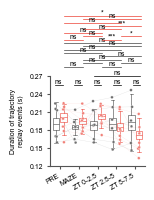

In [55]:
# df1 = subjects.GroupData().candidate_PBE_duration_bootstrap
if "jump_thresh" in locals():
    save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"
    
pbe_duration = getattr(subjects.GroupData(), f"continuous_replay_PBE_duration{save_append}")

# boot_df = subjects.GroupData().continuous_replay_PBE_duration_bootstrap
# dur_df = grpdata.continuous_replay_PBE_duration

boot_df = getattr(subjects.GroupData(), f"continuous_replay_PBE_duration_bootstrap{save_append}")
dur_df = getattr(grpdata, f"continuous_replay_PBE_duration{save_append}")
mean_df = (
    dur_df.groupby(["grp", "session", "zt"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)


fig = subjects.SdFig().fig4(8, 6)

# for i, df in enumerate([df1, df2]):
ax = fig.subplot(fig.gs[3, 1])

results_list = []
p1 = Plotter(data=boot_df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    verbose=True,
))

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=mean_df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)
# print(ax.get_ybound())
ax.set_yticks([0.12, 0.15, 0.18, 0.21, 0.24, 0.27])

# if i == 1:
#     ax.set_yticks([0.15, 0.20, 0.25])
ax.set_xlabel("")
ax.set_ylabel("Duration of trajectory\nreplay events (s)")
fig.savefig(subjects.figpath_sd / f"continuousReplay_duration_bootstrap{save_append}", format="svg")

In [41]:
filter_stats_df(stats_to_df(results_list), figure="4")

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",1.283e-01,1.569e+00
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",2.672e-01,8.409e-01
3,ZT 2.5-5_NSD,ZT 2.5-5_SD,"get_bootstrap_prob,",4.049e-01,3.833e-01
4,ZT 5-7.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",1.571e-01,1.502e+00
5,ZT 0-2.5_NSD,ZT 5-7.5_SD,"get_bootstrap_prob,",1.406e-01,1.584e+00
6,ZT 0-2.5_NSD,ZT 2.5-5_NSD,"get_bootstrap_prob_paired,",3.452e-01,-2.501e-03
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",3.258e-01,5.841e-03
8,MAZE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",3.987e-01,-3.289e-03
9,ZT 2.5-5_NSD,ZT 5-7.5_NSD,"get_bootstrap_prob_paired,",3.561e-01,-2.547e-03
12,PRE_NSD,ZT 0-2.5_NSD,"get_bootstrap_prob_paired,",3.788e-01,2.552e-03


In [57]:
# Get total # trajectory events
dur_df.groupby(["grp"]).count()

,pbe_duration,zt,session
grp,,,
NSD,17742,17742,17742
SD,15005,15005,15005


### EDF 6D: Duration in 1h blocks

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: p <= 2.50e-02

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:1.226e-01 Stat=1.598e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:2.635e-01 Stat=8.581e-01
ZT 0-1_NSD vs. ZT 0-1_SD: get_bootstrap_prob, P_val:1.363e-01 Stat=1.519e+00
1-2_NSD vs. 1-2_SD: get_bootstrap_prob, P_val:1.064e-01 Stat=1.755e+00
2-3_NSD vs. 2-3_SD: get_bootstrap_prob, P_val:1.956e-01 Stat=1.194e+00
3-4_NSD vs. 3-4_SD: get_bootstrap_prob, P_val:3.360e-01 Stat=6.437e-01
ZT 4-5_NSD vs. ZT 4-5_SD: get_bootstrap_prob, P_val:2.843e-01 Stat=8.737e-01
ZT 5-6_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:2.840e-01 Stat=9.072e-01
ZT 0-1_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:9.320e-02 Stat=1.911e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: p <= 2.50e-02

ZT 0-1_NSD vs. 1-2_NSD: get_bootstrap_prob_paired, P_val:1.648e-01 Stat=6.138e-03
PRE_NSD v

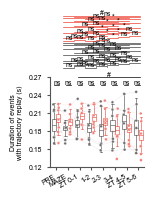

In [63]:
df = add_zt_str(subjects.GroupData().continuous_replay_PBE_duration_1h_blocks_bootstrap, epoch_str=("0-1", "4-5", "5-6"))
dur_df = add_zt_str(grpdata.continuous_replay_PBE_duration_1h_blocks, epoch_str=("0-1", "4-5", "5-6"))
mean_df = (
    dur_df.groupby(["grp", "session", "zt"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)


fig = subjects.SdFig().fig4(8, 6)

# for i, df in enumerate([df1, df2]):
ax = fig.subplot(fig.gs[3, 1])

results_list = []
p1 = Plotter(data=df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=0.025,
    alpha_within=0.025,
    fontsize=5,
    verbose=True,
))

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=mean_df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)
# print(ax.get_ybound())
ax.set_yticks([0.12, 0.15, 0.18, 0.21, 0.24, 0.27])

# if i == 1:
#     ax.set_yticks([0.15, 0.20, 0.25])
ax.set_xlabel("")
ax.set_ylabel("Duration of events\nwith trajectory replay (s)")
fig.savefig(subjects.figpath_sd / "continuous_replay_duration_bootstrap_1h_blocks", format="svg")

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:1.226e-01 Stat=1.598e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:2.635e-01 Stat=8.581e-01
ZT 0-1_NSD vs. ZT 0-1_SD: get_bootstrap_prob, P_val:1.363e-01 Stat=1.519e+00
ZT 4-5_NSD vs. ZT 4-5_SD: get_bootstrap_prob, P_val:2.843e-01 Stat=8.737e-01
ZT 5-6_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:2.840e-01 Stat=9.072e-01
ZT 0-1_NSD vs. ZT 5-6_SD: get_bootstrap_prob, P_val:9.320e-02 Stat=1.911e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

ZT 0-1_NSD vs. ZT 4-5_NSD: get_bootstrap_prob_paired, P_val:3.639e-01 Stat=-3.550e-03
PRE_NSD vs. MAZE_NSD: get_bootstrap_prob_paired, P_val:3.230e-01 Stat=5.879e-0

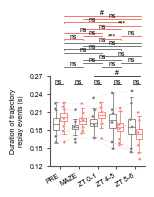

In [47]:
df = add_zt_str(cut_1h_epochs(subjects.GroupData().continuous_replay_PBE_duration_1h_blocks_bootstrap), epoch_str=("0-1", "4-5", "5-6"))
dur_df = add_zt_str(cut_1h_epochs(grpdata.continuous_replay_PBE_duration_1h_blocks), epoch_str=("0-1", "4-5", "5-6"))
mean_df = (
    dur_df.groupby(["grp", "session", "zt"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)


fig = subjects.SdFig().fig4(8, 6)

# for i, df in enumerate([df1, df2]):
ax = fig.subplot(fig.gs[3, 1])

results_list = []
p1 = Plotter(data=df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
results_list.append(p1.boxplot_sd2(palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_within=get_bootstrap_prob_paired,
    stat_across=get_bootstrap_prob,
    alpha_across=[0.05, 0.01, 0.001],
    alpha_within=[0.025, 0.005, 0.0005],
    fontsize=5,
    verbose=True,
))

palette_light = subjects.colors_sd_light()
p2 = Plotter(data=mean_df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd(palette=palette_light)
# print(ax.get_ybound())
ax.set_yticks([0.12, 0.15, 0.18, 0.21, 0.24, 0.27])

# if i == 1:
#     ax.set_yticks([0.15, 0.20, 0.25])
ax.set_xlabel("")
ax.set_ylabel("Duration of trajectory\nreplay events (s)")
fig.savefig(subjects.figpath_sd / "continuous_replay_duration_bootstrap_1h_blocks_simplified", format="svg")

In [65]:
dur_df.groupby(["grp"]).count()

,pbe_duration,zt,session
grp,,,
NSD,15866,15866,15866
SD,13911,13911,13911


In [49]:
results_df = filter_stats_df(stats_to_df(results_list), figure="EDF6D")
results_df.to_csv("/home/nkinsky/Documents/sleep_deprivation/ProcessedData/replay_duration_1h_blocks_stats.csv")
results_df

,comp1,comp2,test,pval,test_stat
0,MAZE_NSD,MAZE_SD,"get_bootstrap_prob,",1.226e-01,1.598e+00
1,PRE_NSD,PRE_SD,"get_bootstrap_prob,",2.635e-01,8.581e-01
3,ZT 4-5_NSD,ZT 4-5_SD,"get_bootstrap_prob,",2.843e-01,8.737e-01
4,ZT 5-6_NSD,ZT 5-6_SD,"get_bootstrap_prob,",2.840e-01,9.072e-01
5,ZT 0-1_NSD,ZT 5-6_SD,"get_bootstrap_prob,",9.320e-02,1.911e+00
6,ZT 0-1_NSD,ZT 4-5_NSD,"get_bootstrap_prob_paired,",3.639e-01,-3.550e-03
7,PRE_NSD,MAZE_NSD,"get_bootstrap_prob_paired,",3.230e-01,5.879e-03
8,MAZE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",2.116e-01,-7.470e-03
9,ZT 4-5_NSD,ZT 5-6_NSD,"get_bootstrap_prob_paired,",7.930e-02,9.170e-03
12,PRE_NSD,ZT 0-1_NSD,"get_bootstrap_prob_paired,",4.337e-01,-1.591e-03
